### The Income Fluctuation Problem

We are interested in solving the following problem:
$$
\begin{aligned}
V(a, z)= & \max _{a^{\prime}} u(c)+\beta \sum_{y^{\prime}} \pi_{y y^{\prime}} V\left(a^{\prime}, y^{\prime}\right) \\
\text { s.t. } & \\
& c+a^{\prime}=(1+r) a+wz(1-\tau) +\phi \\
& a^{\prime} \geq a_{\text {min }}
\end{aligned}
$$

This problem yields the Euler equation
$$
u^{\prime}(c(a, z)) \geq \beta(1+r) \sum_{y^{\prime}} \pi_{y y^{\prime}}\left[u^{\prime}\left(c\left(a^{\prime}, z^{\prime}\right)\right)\right]
$$

Note, equality of the Euler equation holds if $a^{\prime}>a_{\min }$.

We are trying to solve for the optimal consumption policy $c(a, y)$, which is an invariant function of the states, satisfies the Euler equation, and does not violate the borrowing constraint.

## Stationary Recursive Equilibrium ##

Value functions $V$, policy functions $a^\prime$, $c$, optimal firm policies $H$ and $K$, prices $r$ and $w$ and a stationary measure of wealth $\lambda$ such that

1) Households take $r$ and $w$ as given and solve $a^\prime(a,z)$ to maximise value function $V$.

2) Firms take $r$ and $w$ as given and choose $K$ and $H$ to satisfy $r + \delta = F_K(K,H)$ and $w = F_H(K,H)$. Household with productivity $z$ gets wage $z w$. Firms are competitive sector with representative firm representation.

Moreover, markets must clear. Thus we have
Labour (inelastically supplied at 1 unit each.)
$$H = \int z d\lambda^*$$
Capital
$$K = \int a^\prime (a,z) d\lambda^*$$
Good
$$ \int c(a,z) d\lambda^* + \delta K = F(K,H) $$

Finally, the stationary distribution satisfies

$$ \lambda^*(S) = \int Q((a,z),S)d\lambda^* $$

The transition function is the probability an individual with current state $(a,z)$ transits into the set $S$.

$$ Q((a,z), A \times Z) = \mathbb{I}_{a^\prime(a,z)\in A} \sum_{z^\prime \in Z} \pi(z,z^\prime)$$

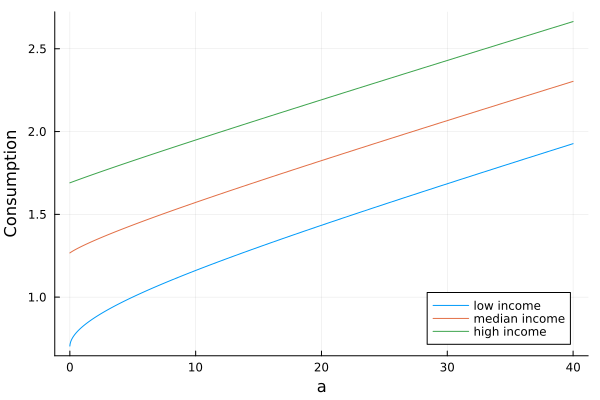

In [1]:
using LinearAlgebra
using Plots
using Interpolations, Roots
using Optim
using Statistics
using Distributions
using LaTeXStrings

# Parameters
α = 0.35
δ = 0.08
γ = 4.0
a_min = 0.0
τ = 0.36
β = 0.97

util(c) = (c^(1-γ) - 1) / (1-γ)

# Productivity Grid
z_grid = [0.3, 0.7, 1, 1.3, 1.7]
# Transition matrix
A = [0.969909 0.029317 0.000332 0.000002 0.000000;
     0.007329 0.970075 0.021989 0.000166 0.000000;
     0.000055 0.014659 0.970130 0.014659 0.000055;
     0.000000 0.000166 0.021989 0.970075 0.007329;
     0.000000 0.000002 0.000332 0.029317 0.969909]


## Solve the inner loop of the Aiyagari Model from Floden and Linde (2001)
## Using the endogenous grid method.

function IncomeFluctuationProblem(r, w, φ, τ, z_grid, A)
    # Parameters
    z_num = 5
    a_min = 0.0
    a_max = 40.0
    a_grid_size = 100
    a_grid = LinRange(0, z_num, a_grid_size)
    a_prime_grid = (exp.(a_grid) .- 1) ./ (exp(z_num) - 1) .* (a_max - a_min) .+ a_min

    # Step 2: Make guess
    policy = zeros(z_num, a_grid_size)
    for i in 1:z_num
        for j in 1:a_grid_size
            policy[i, j] = (1-τ) * w * z_grid[i] + r * a_prime_grid[j]
        end
    end

    # Initialize error and tolerance
    err = 1.0
    tol = 1e-7
    util_prime(c) = c.^(-γ)

    while err > tol
        # Step 3: Compute RHS of the Euler equation
        B = zeros(z_num, a_grid_size)
        for i in 1:z_num
            for j in 1:a_grid_size
                B[i, j] = β * (1 + r) * dot(A[i, :] , util_prime(policy[:, j]))
            end
        end

        # Step 4: Compute c_hat (c_endo)
        c_endo = B.^(-1/γ)

        # Step 5: Compute a_star rearranging budget constraint
        a_star = zeros(z_num, a_grid_size)
        for i in 1:z_num
            for j in 1:a_grid_size
                a_star[i, j] = (c_endo[i, j] + a_prime_grid[j] - (1-τ) * w * z_grid[i] - φ) / (1 + r)
            end
        end

        # Step 6: Compute new guess
        policy_prime = zeros(z_num, a_grid_size)
        for i in 1:z_num
            interp_func = LinearInterpolation(a_star[i, :], c_endo[i, :], extrapolation_bc=Line())
            for j in 1:a_grid_size
                if a_prime_grid[j] < a_star[i, 1]
                    policy_prime[i, j] = w * (1-τ) * z_grid[i] + (1 + r) * a_prime_grid[j] - a_min + φ
                else
                    policy_prime[i, j] = interp_func(a_prime_grid[j])
                end
            end
        end

        # Step 7: Update error
        err = maximum(abs.(policy - policy_prime))

        # Update guess
        policy = copy(policy_prime)
    end

    a_prime = zeros(z_num, a_grid_size)
    for i in 1:z_num
        a_prime[i, :] = (1+r) .* a_prime_grid .+ (1-τ) * w * z_grid[i] .+ φ .- policy[i, :]
    end

    return policy, a_prime, a_prime_grid
end

r_0 = 0.02
H = 1.0

F_K(K) = α * K^(α-1) * H^(1-α)
F_H(K) = (1-α) * K^α * H^(-α)
F_K_inv(r) = ((1/α) * (r+δ) * H^(1-α))^(1/(α-1))

K = F_K_inv(r_0)
w = F_H(K)
φ = τ*w*H

cons, a_prime, a_grid = IncomeFluctuationProblem(r_0, w, φ, τ, z_grid, A)

# plot commands
plot(a_grid, cons[1, :], label="low income")
plot!(a_grid, cons[3, :], label="median income")
plot!(a_grid, cons[5, :], label="high income")
xlabel!("a")
ylabel!("Consumption")

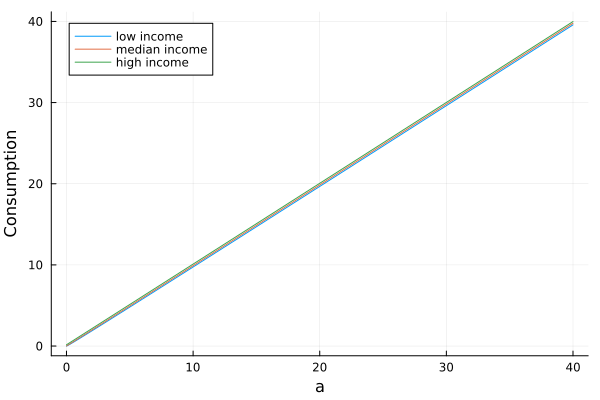

In [2]:
plot(a_grid, a_prime[1, :], label="low income")
plot!(a_grid, a_prime[3, :], label="median income")
plot!(a_grid, a_prime[5, :], label="high income")
xlabel!("a")
ylabel!("Consumption")

# Now Solve Outer Loop for Aiyagari #

In [8]:
function simulate_agents(r,w,τ,φ, A,cons,a_prime,a_grid,z_grid)
    n_agents = 2000
    n_steps = 10000
    
    interpolated_a_prime = interpolate((z_grid,a_grid), a_prime, Gridded(Linear()))
    extrapolated_a_prime = extrapolate(interpolated_a_prime, Line())
    
    agent_shocks = zeros(n_agents, n_steps)
    
    asset_distribution = zeros(n_agents, n_steps)
    asset_distribution[:,1] .= 2
    
    # Compute stationary distribution
    eigenvec = eigvecs(A')
    stationary_dist = abs.(real(eigenvec[:,end])) # Taking the last column which corresponds to eigenvalue 1
    stationary_dist /= sum(stationary_dist) # Normalize

    # Ensure normalization of probabilities
    normalize_probs!(p) = p / sum(p)

    # Function to simulate a single step given current state
    function simulate_step(current_state, A)
        state_probs = normalize_probs!(A[current_state, :])
        return rand(Categorical(state_probs)) # Draw next state based on current row in A
    end

    # Function to simulate Markov chain
    function simulate_markov_chain(A, stationary_dist, n_steps)
        states = zeros(Int, n_steps)
        # Initial state drawn from stationary distribution
        states[1] = rand(Categorical(normalize_probs!(stationary_dist)))
        for t in 2:n_steps
            states[t] = simulate_step(states[t-1], A)
        end
        return states
    end
    
    
    for i in 1:n_agents
        agent_shocks[i,:] = simulate_markov_chain(A, stationary_dist, n_steps)
    end
    
    for i in 1:n_agents
        for t in 1:n_steps-1
            current_assets = asset_distribution[i,t]
            # current income
            it = Int(agent_shocks[i,t])
            current_income = z_grid[it]
            a_prime_int = extrapolated_a_prime(current_income, current_assets)
            asset_distribution[i,t+1] = a_prime_int
        end
    end
    
    stationary_wealth = asset_distribution[:,end]
    A_r = mean(stationary_wealth)
    
    return A_r
end

simulate_agents (generic function with 1 method)

In [9]:
## Bisection Method - Doesn't Work, so I do another

r_guess = 0.02

function solve_economy(r_guess)
    H = 1.0
    r_0 = r_guess
    F_K(K) = α * K^(α-1) * H^(1-α)
    F_H(K) = (1-α) * K^α * H^(-α)
    F_K_inv(r) = ((1/α) * (r+δ) * H^(1-α))^(1/(α-1))
    
    A_r = 10
    K = F_K_inv(r_guess)
    
    r_1 = 0
    tol = 1e-04
    maxits = 10
    its = 0
    
    while (A_r - K > tol) && (its < maxits)
        
        
        K = F_K_inv(r_0)
        w = F_H(K)
        φ = τ*w*H
        cons, a_prime, a_grid = IncomeFluctuationProblem(r_0, w, φ, τ, z_grid, A)
        
        #interpolated_a_prime = interpolate((z_grid,a_grid), a_prime, Gridded(Linear()))

        A_r = simulate_agents(r_0,w,τ,φ, A,cons,a_prime,a_grid,z_grid)

        # Update interest rate
        r_1 = F_K(A_r) - δ

        r_0 = 0.3*copy(r_1) + 0.7*copy(r_0)
        its = its + 1
        
        println("=========================")
        println("A_r is ", A_r, " | K is ", K)
        println("Iteration", its)
    end
    
    return A_r, r_0
end
    
    

solve_economy (generic function with 1 method)

In [10]:
n = 30
r = range(0, stop=0.0255, length=n)
A_rr = zeros(n)
K_r  = zeros(n)
i = 0
for r_0 in r
    i = i+1
    K = F_K_inv(r_0)
    w = F_H(K)
    φ = τ*w*H
    cons, a_prime, a_grid = IncomeFluctuationProblem(r_0, w, φ, τ, z_grid, A)

    A_r = simulate_agents(r_0,w,τ,φ, A,cons,a_prime,a_grid,z_grid)
    A_rr[i] = A_r
    K_r[i] = F_K_inv(r_0)
end

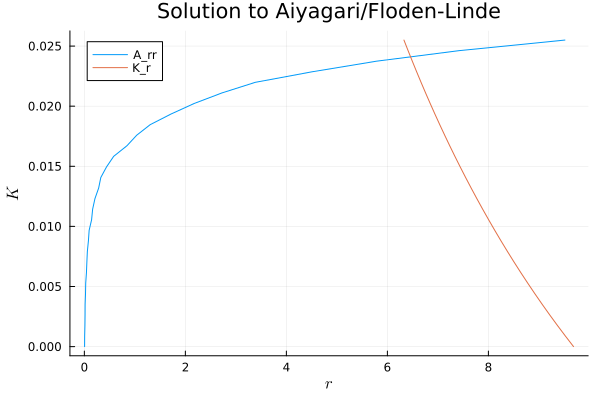

In [11]:
using LaTeXStrings
# Plotting
plot(A_rr, r, label="A_rr")
plot!(K_r, r, label="K_r")

xlabel!("$(latexstring("r"))")
ylabel!("$(latexstring("K"))")
title!("Solution to Aiyagari/Floden-Linde")

In [12]:
using Interpolations

# Example data
x = r # Common domain for both functions
y1 = A_rr  # First function (increasing then decreasing)
y2 = K_r  # Second function (decreasing then increasing)

# Find approximate crossing point using linear interpolation
function find_crossing(x, y1, y2)
    for i in 1:length(x)-1
        if (y1[i] - y2[i]) * (y1[i+1] - y2[i+1]) < 0  # Change in sign indicates crossing
            # Linear interpolation to estimate the crossing point
            slope = (x[i+1] - x[i]) / (y1[i+1] - y2[i+1] - y1[i] + y2[i])
            x_crossing = x[i] + slope * (y2[i] - y1[i])
            y_crossing = (y1[i] + y1[i+1]) / 2  # Average of y values for interpolation
            return x_crossing, y_crossing
        end
    end
    return nothing, nothing  # No crossing found
end

crossing_x, crossing_y = find_crossing(collect(x), y1, y2)

println("Approximate Interest Rate: r = $crossing_x")
println("Corresponding Capital: K = $crossing_y")


Approximate Interest Rate: r = 0.024104533069228506
Corresponding Capital: K = 6.601751910225611
